In [5]:
!pip install opencv-python

In [6]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sn
import pandas as pd 
import numpy as np 
import glob
import cv2
import os

layers = keras.layers
models = keras.models

In [7]:
# Define a train test path

train_dir = 'C:/Users/HP/Downloads/dataset/train'
test_dir = 'C:/Users/HP/Downloads/dataset/test'
train_dir

'C:/Users/HP/Downloads/dataset/train'

In [8]:
benign_train_images = glob.glob(train_dir+"/benign/*")
malignant_train_images = glob.glob(train_dir+"/malignant/*")
print(len(benign_train_images))
print(len(malignant_train_images))

1440
1197


In [9]:
benign_test_images = glob.glob(test_dir+"/benign/*")
malignant_test_images = glob.glob(test_dir+"/malignant/*")
print(len(benign_test_images))
print(len(malignant_test_images))

360
300


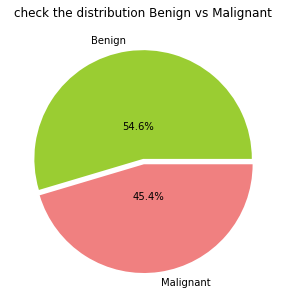

In [10]:
# class class distibution ratio

plt.figure(figsize=(7, 5))
plt.pie(x=np.array([len(benign_train_images), len(malignant_train_images)]), 
        autopct='%1.1f%%',colors = ["yellowgreen", "lightcoral"], 
        explode=[0,0.05], labels=["Benign", "Malignant"], pctdistance=0.3)
plt.title("check the distribution Benign vs Malignant", fontsize=12);

Benign


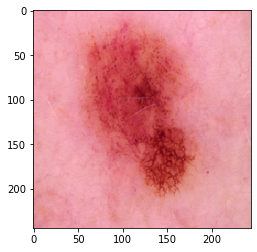

Malignant


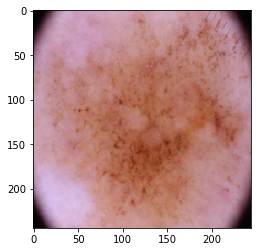

In [11]:
import keras.utils as image
import numpy as np
image_path = "C:/Users/HP/Downloads/dataset/test/benign/1261.jpg"
new_img = image.load_img(image_path, target_size=(244, 244))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
print("Benign")
plt.imshow(new_img)
plt.show()
image_path = "C:/Users/HP/Downloads/dataset/test/malignant/1080.jpg"
new_img = image.load_img(image_path, target_size=(244, 244))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
print("Malignant")
plt.imshow(new_img)
plt.show()

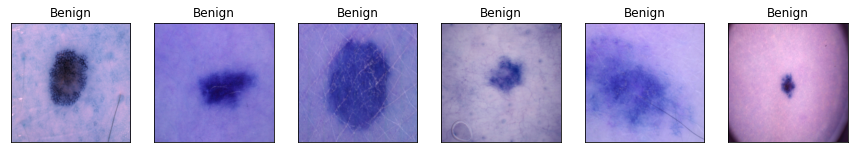

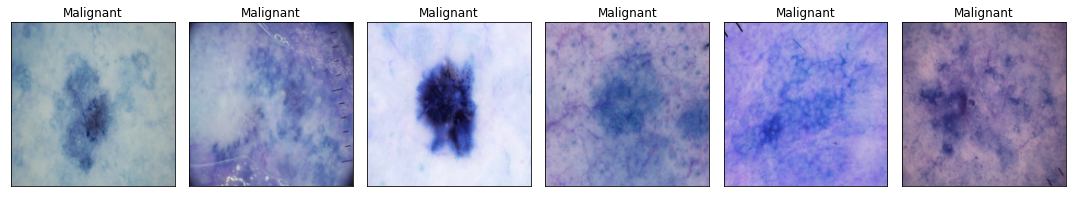

In [12]:
# see that we have an imbalanced dataset. Hence, we will be using image augmentation techniques to compensate for this.

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(benign_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Benign")
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(malignant_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("Malignant")
fig.tight_layout()    
plt.show()

In [13]:
# apply data Augmentation technique
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255, #convert the pixels in range [0,255] to range [0,1]
    rotation_range=40, #randomly rotates the image up to 40 degrees
    width_shift_range=0.2, #shifts the image vertically
    height_shift_range=0.2, #shift the image horizontally
    shear_range=0.2,
    zoom_range=0.2,#zoom the images in or out
    horizontal_flip=True, # flip the image horizontally
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255.,)

#To load a series of images from disk, you now call the flow_from_directory() method 
#of the ImageDataGenerator instance instead of the flow() method (for loading images from memory)
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size = (220, 220))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'binary', target_size=(220, 220))

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [14]:
train_class = train_generator.class_indices
train_class

{'benign': 0, 'malignant': 1}

In [15]:
#Keras Sequential API, where you have just to add one layer at a time, starting from the input.
model = models.Sequential() 
#2D convolution layer: This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. 
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(220,220,3)))
model.add(layers.MaxPooling2D((2, 2))) #Downsamples the input
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) #Flattens the input i.e to [X,1]
model.add(layers.Dropout(0.5)) #randomly selected neurons are ignored during training i.e 0.5-> 50%
#add dense layers so that the model can learn more complex functions and classify for better results.
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 128)      0

In [16]:
from tensorflow.keras import optimizers
#---compile the model---    
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [17]:
#---train the model---
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=test_generator)

Epoch 1/20
100/100 [==============================] - 122s 1s/step - loss: 0.6984 - accuracy: 0.5578 - val_loss: 0.6678 - val_accuracy: 0.4561
Epoch 2/20
100/100 [==============================] - 684s 7s/step - loss: 0.6631 - accuracy: 0.6410 - val_loss: 0.5465 - val_accuracy: 0.7636
Epoch 3/20
100/100 [==============================] - 102s 1s/step - loss: 0.5661 - accuracy: 0.7031 - val_loss: 0.5217 - val_accuracy: 0.7273
Epoch 4/20
100/100 [==============================] - 96s 957ms/step - loss: 0.4797 - accuracy: 0.7690 - val_loss: 0.4755 - val_accuracy: 0.7379
Epoch 5/20
100/100 [==============================] - 93s 927ms/step - loss: 0.4602 - accuracy: 0.7810 - val_loss: 0.4303 - val_accuracy: 0.7727
Epoch 6/20
100/100 [==============================] - 93s 926ms/step - loss: 0.4643 - accuracy: 0.7707 - val_loss: 0.4466 - val_accuracy: 0.7742
Epoch 7/20
100/100 [==============================] - 93s 923ms/step - loss: 0.4459 - accuracy: 0.7737 - val_loss: 0.4641 - val_accuracy

In [18]:
model.evaluate(train_generator)

132/132 [==============================] - 44s 334ms/step - loss: 0.3958 - accuracy: 0.8195


[0.3957512676715851, 0.8194918632507324]

In [19]:
model.evaluate(test_generator)

33/33 [==============================] - 7s 200ms/step - loss: 0.3857 - accuracy: 0.8076


[0.3856613039970398, 0.8075757622718811]

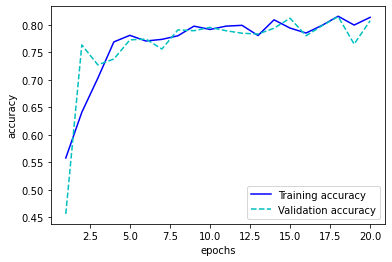

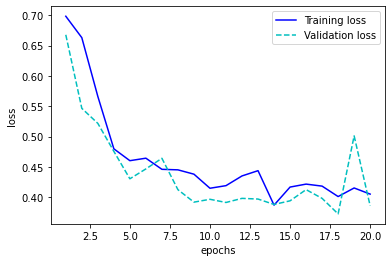

In [20]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,color='b', label='Training accuracy')
plt.plot(epochs, val_accuracy,'--',color='c', label='Validation accuracy')
#plt.title('Training and validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.legend()
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'--',color='c', label='Validation loss')
#plt.title('Training and validation loss')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [21]:
!pip install pyyaml h5py

In [22]:
model.save('model.h5')